In [29]:
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from src.dataset.kay import load_dataset
from src.utils.utils import convert_arr_to_img

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [3]:
all_data = load_dataset(data_path="./../data/")

In [4]:
all_data["stimuli_test"].shape

(120, 128, 128)

In [5]:
x_trainval = convert_arr_to_img(stimulus_img_arr=all_data["stimuli"])
y_trainval = all_data["train_labels"][:, 0]
x_test = convert_arr_to_img(stimulus_img_arr=all_data["stimuli_test"])
y_test = all_data["test_labels"][:, 0]

x_trainval.shape, y_trainval.shape, x_test.shape, y_test.shape

((1750, 128, 128), (1750,), (120, 128, 128), (120,))

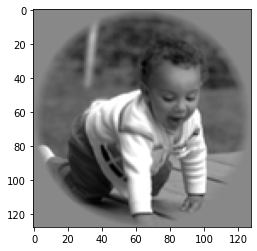

In [6]:
plt.imshow(x_trainval[0], cmap="gray")

In [7]:
class2idx = {k:i for i,k in enumerate(np.unique(y_trainval))}
idx2class = {v:k for k,v in class2idx.items()}

In [8]:
dataset_mean = 0.5
dataset_std = 0.5

img_transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(dataset_mean, dataset_std)
    ])
}

class StimulusData(Dataset):
    def __init__(self, x_img, y_lbl, img_transform, class2idx):
        self.x_img = x_img
        self.y_lbl = y_lbl
        self.img_transform = img_transform
        self.class2idx = class2idx
        
    def __getitem__(self, idx):
        x = Image.fromarray(self.x_img[idx].astype(np.uint8))
        y = torch.tensor(self.class2idx[self.y_lbl[idx]], dtype=torch.long)
        
        if self.img_transform:
            x = self.img_transform(x)
            
        return x, y
        
    def __len__(self):
        assert len(self.x_img) == len(self.y_lbl)
        return len(self.x_img)

In [10]:
train_dataset = StimulusData(x_img=x_trainval, 
                             y_lbl = y_trainval, 
                             img_transform = img_transform["train"], 
                             class2idx = class2idx)

test_dataset = StimulusData(x_img = x_test, 
                            y_lbl = y_test, 
                            img_transform = img_transform["test"], 
                            class2idx = class2idx)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=128)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=8)

In [11]:
class StimulusClassifier(nn.Module):
    def __init__(self, num_classes):
        super(StimulusClassifier, self).__init__()
                
        self.block1 = self.conv_block(c_in=1, c_out=32, kernel_size=3, stride=1, padding=1)
        self.block2 = self.conv_block(c_in=32, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block4 = self.conv_block(c_in=128, c_out=64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(in_features=4096, out_features=num_classes)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
        x = self.maxpool(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.block4(x)
        x = self.maxpool(x)
        
        x = x.flatten(start_dim=1)    
        x = self.fc(x)
    
        return x
    
    
    def conv_block(self, c_in, c_out, **kwargs):
        return  nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
        )

In [12]:
model = StimulusClassifier(num_classes=len(class2idx))

In [13]:
x,y = next(iter(train_loader))

In [14]:
x.shape, y.shape, model(x).shape

/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([128, 1, 128, 128]), torch.Size([128]), torch.Size([128, 8]))

In [15]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

def multi_acc(y_pred: "torch.tensor", y_test: "torch.tensor") -> float:
    """
    Calculate Accuracy.
    -------------------
        - Input: Predicted and actual output values.
        - Output: Accuracy percentage.
    """
    y_pred_softmax = torch.softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc


def print_log(
    e,
    epochs,
    avg_train_epoch_loss,
    avg_train_epoch_acc,
):
    """
    Print training logs.
    """
    print(
        f"Epoch {e+0:02}/{epochs}: | Train Loss: {avg_train_epoch_loss:.5f} | Train Acc: {avg_train_epoch_acc:.3f}%"
    )



In [16]:
epochs = 20
acc_stats = {"train": []}
loss_stats = {"train": []}
    
for e in tqdm(range(1, epochs + 1)):

    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for i, (x_train_batch, y_train_batch) in enumerate(train_loader):
        x_train_batch, y_train_batch = (
            x_train_batch.to(device),
            y_train_batch.to(device),
        )

        optimizer.zero_grad()

        y_train_pred = model(x_train_batch).squeeze()

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    avg_train_epoch_loss = train_epoch_loss / len(train_loader)
    avg_train_epoch_acc = train_epoch_acc / len(train_loader)

    loss_stats["train"].append(avg_train_epoch_loss)
    acc_stats["train"].append(avg_train_epoch_acc)

    print_log(
            e,
            epochs,
            avg_train_epoch_loss,
            avg_train_epoch_acc,
        )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01/20: | Train Loss: 1.60875 | Train Acc: 38.929%
Epoch 02/20: | Train Loss: 1.43821 | Train Acc: 49.357%
Epoch 03/20: | Train Loss: 1.50040 | Train Acc: 51.429%
Epoch 04/20: | Train Loss: 1.45348 | Train Acc: 51.929%
Epoch 05/20: | Train Loss: 1.45470 | Train Acc: 57.429%
Epoch 06/20: | Train Loss: 1.42501 | Train Acc: 56.643%
Epoch 07/20: | Train Loss: 1.37428 | Train Acc: 57.714%
Epoch 08/20: | Train Loss: 1.16396 | Train Acc: 60.429%
Epoch 09/20: | Train Loss: 1.05383 | Train Acc: 66.643%
Epoch 10/20: | Train Loss: 0.96372 | Train Acc: 65.714%
Epoch 11/20: | Train Loss: 0.94053 | Train Acc: 66.143%
Epoch 12/20: | Train Loss: 0.88615 | Train Acc: 69.071%
Epoch 13/20: | Train Loss: 0.72866 | Train Acc: 74.286%
Epoch 14/20: | Train Loss: 0.68979 | Train Acc: 76.286%
Epoch 15/20: | Train Loss: 0.63582 | Train Acc: 78.857%
Epoch 16/20: | Train Loss: 0.56605 | Train Acc: 81.929%
Epoch 17/20: | Train Loss: 0.53740 | Train Acc: 81.857%
Epoch 18/20: | Train Loss: 0.46456 | Train Acc: 

In [18]:
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=8)

In [20]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim=1)

        for i in y_pred_tag.squeeze().cpu().numpy().tolist():
            y_pred_list.append(i)

        for i in y_batch.squeeze().cpu().numpy().tolist():
            y_true_list.append(i)

  0%|          | 0/15 [00:00<?, ?it/s]

In [38]:
def plot_confusion_matrix(y_true: list, y_pred: list, idx2class):
    """Plots the confusion matrix.
    Parameters
    ----------
    y_true: list
        A 1-d numpy array or list of true values.
    y_pred: list
        A 1-d numpy array or list of predicted values.
    """

    df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(
        columns=idx2class, index=idx2class
    )

    plt.figure(figsize=(12, 10))
    sns.heatmap(df, annot=True, fmt="g", cbar=False, annot_kws={"fontsize": 14})
    plt.xlabel("Pred", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

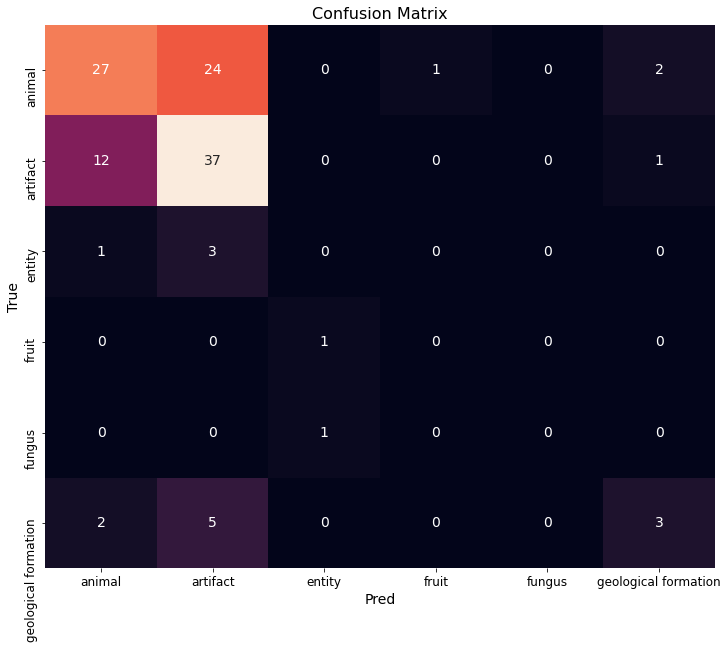

In [39]:
plot_confusion_matrix(y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class)